# From Data to Paper: Everything you need to go from random data to a LaTeX worthy table and figure

In this python lesson we'll be working within the confines of this Jupyter Notebook to download data from the NASA Exoplanet Archive, plot it in various ways and reproduce the results of this research note: http://iopscience.iop.org/article/10.3847/2515-5172/aac728

If at any point you have questions or would like to see how to do something in particular please speak up or feel free to email me: laura.mayorga@cfa.harvard.edu

## 1. We're going to need some stuff

In [1]:
# This will grant us access to many array handling functions 
# so that we can do math and is almost always loaded
import numpy as np

# We wanna be able to plot stuff!
# We've chosen to rename the module to save us time and make the code clear
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# We need to be able to read and write stuff!
from astropy.table import QTable
from astropy.io import ascii
import pandas as pd

# We'll be doing some computations and these constants are super useful
from astropy.constants import sigma_sb, R_sun, R_earth, R_jup, \
                        L_sun, au, M_sun, M_jup, M_earth, G
    
# For a non-astro-centric unit conversion library, see https://pypi.org/project/unyt
# There's also pint
from astropy import units as u

# Download files here: https://tinyurl.com/laura-python

## Did you know you can call command line stuff from within python?

In [2]:
# These are the magic queries to get you the files you need!
import subprocess as subp

# This will download planets.csv
command = ['wget', 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/'+\
            'nstedAPI/nph-nstedAPI?table=exoplanets'+\
            '&select=pl_hostname,pl_rade,pl_eqt'+\
            '&where=pl_rade>0 and pl_eqt>0'+\
            '&format=csv', '-O', 'planets.csv']
neastat = subp.call(command)

# This will download sullivan.txt
command = ['wget', 'http://iopscience.iop.org/0004-637X/809/1/77/suppdata/apj516470t6_mrt.txt',
          '-O', 'sullivan.txt']
sullystat = subp.call(command)

# This will download inflation.csv
command = ['wget', 'https://www.dropbox.com/s/i0usuh5xtwk5pfg/jupMax.txt?dl=0',
           '-O', 'inflation.csv']
infstat=subp.call(command)

# This checks if the commands worked!
if neastat!=0 or sullystat!= 0 or infstat != 0:
    print('SOMETHING BROKE ASK FOR HELP!!')
else:
    print('Queries worked successfully')

Queries worked successfully


The unit package feels like cheating but its fantastic!

In [3]:
print("The Radius of the Sun:")

print("\t in solar radii: \t\t{0:0.3f}".format(R_sun.to(u.R_sun)))
print("\t in meters: \t\t\t{0:0.3e}".format(R_sun.to(u.m)))
print("\t in astronomical units: \t{0:0.3f}".format(R_sun.to(u.AU)))

grav = G*M_earth/R_earth**2

print("The Earth's gravity is: \t\t{0:0.3f} \n"
      "\tor in cgs units: \t\t{1:0.3f} \n"
      "\tor your favorite crazy unit: \t{2:0.3f}".format(\
                        grav, grav.cgs, grav.to(u.lightyear/u.year**2)))

The Radius of the Sun:
	 in solar radii: 		1.000 solRad
	 in meters: 			6.957e+08 m
	 in astronomical units: 	0.005 AU
The Earth's gravity is: 		9.798 m / s2 
	or in cgs units: 		979.840 cm / s2 
	or your favorite crazy unit: 	1.031 lyr / yr2


## 2. Let's get some data!
There are multiple ways of doing this so lets try a couple and see why some might be better than others in this case.

In [4]:
with open('sullivan.txt', 'r') as f:
    sullivan = ascii.read(f.readlines())
with open('planets.csv', 'r') as f:
    nexsci = ascii.read(f.readlines())
    
# Now you should open the files and look at them yourself.
# ascii.read handles the header of sullivan.txt, and is astropy-centric.
# This format is known as Enhanced Character Separated Values
# It handles units and descriptions in data table.

# planets.csv is in the more common Common Separated Value format
# It allows only a simple label header, along with data values

print(sullivan.info)
print(nexsci.info)

<Table length=1984>
  name   dtype   unit                  description                 
------- ------- ------ --------------------------------------------
  RAdeg float64    deg   Right Ascension in decimal degrees (J2000)
  DEdeg float64    deg       Declination in decimal degrees (J2000)
     Rp float64   Rgeo              Planetary radius in Earth units
    Per float64      d                                       Period
      S float64                 Planetary insolation in Earth units
      K float64  m / s                Radial-velocity semiamplitude
     R* float64 solRad                               Stellar radius
   Teff float64      K                Stellar effective temperature
   Vmag float64    mag                    Apparent V band magnitude
   Imag float64    mag                 Apparent I_C_ band magnitude
   Jmag float64    mag                    Apparent J band magnitude
  Ksmag float64    mag                 Apparent K_s_ band magnitude
     DM float64    mag      

In this case both are Tables (analogous to the Pandas DataFrame) and the Sullivan table has all these nice units and information attached. Can we make both of them have units?

Let's try another way

In [5]:
sullivan = QTable.read('sullivan.txt', format='ascii')

nexsci = QTable.read('planets.csv', names=['name', 'Rp', 'Teq'])

# We can change the names and set the units this way!
nexsci['Rp'].unit=u.R_earth
nexsci['Teq'].unit=u.K

print(sullivan.info)
print(nexsci.info)

<QTable length=1984>
  name   dtype   unit                  description                   class  
------- ------- ------ -------------------------------------------- --------
  RAdeg float64    deg   Right Ascension in decimal degrees (J2000) Quantity
  DEdeg float64    deg       Declination in decimal degrees (J2000) Quantity
     Rp float64   Rgeo              Planetary radius in Earth units Quantity
    Per float64      d                                       Period Quantity
      S float64                 Planetary insolation in Earth units   Column
      K float64  m / s                Radial-velocity semiamplitude Quantity
     R* float64 solRad                               Stellar radius Quantity
   Teff float64      K                Stellar effective temperature Quantity
   Vmag float64    mag                    Apparent V band magnitude Quantity
   Imag float64    mag                 Apparent I_C_ band magnitude Quantity
   Jmag float64    mag                    Apparent J ba

That's kind of nice, isn't it? Now instead of each column being a `Column` all the ones with units are `Quantity` objects which have the attached unit information!

But wait what's up with earthRad vs Rgeo for the planet's radius? These aren't the same unit! We're going to have to fix this!

In [7]:
print(sullivan['Rp'].unit, u.R_earth)
sullivan['Rp'].unit = u.R_earth

Rgeo earthRad


AttributeError: can't set attribute

This doesn't work because the unit function has no ability to set the value. It's a protected property of the unit class.

In [8]:
help(sullivan['Rp'].unit)

Help on UnrecognizedUnit in module astropy.units.core object:

class UnrecognizedUnit(IrreducibleUnit)
 |  A unit that did not parse correctly.  This allows for
 |  roundtripping it as a string, but no unit operations actually work
 |  on it.
 |  
 |  Parameters
 |  ----------
 |  st : str
 |      The name of the unit.
 |  
 |  Method resolution order:
 |      UnrecognizedUnit
 |      IrreducibleUnit
 |      NamedUnit
 |      UnitBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __bytes__(self)
 |      Return string representation for unit
 |  
 |  __div__ = _unrecognized_operator(self, *args, **kwargs)
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __ge__ = _unrecognized_operator(self, *args, **kwargs)
 |  
 |  __gt__ = _unrecognized_operator(self, *args, **kwargs)
 |  
 |  __le__ = _unrecognized_operator(self, *args, **kwargs)
 |  
 |  __lt__ = _unrecognized_operator(self, *args, **kwargs)
 |  
 |  __mul__ = _unrecognized_operator(self, *args, **

The way around this is to reset the entire quantity object with the correct unit.

In [9]:
sullivan['Rp'] = sullivan['Rp'].value*u.R_earth
print(sullivan.info)

<QTable length=1984>
  name   dtype    unit                   description                   class  
------- ------- -------- -------------------------------------------- --------
  RAdeg float64      deg   Right Ascension in decimal degrees (J2000) Quantity
  DEdeg float64      deg       Declination in decimal degrees (J2000) Quantity
     Rp float64 earthRad                                              Quantity
    Per float64        d                                       Period Quantity
      S float64                   Planetary insolation in Earth units   Column
      K float64    m / s                Radial-velocity semiamplitude Quantity
     R* float64   solRad                               Stellar radius Quantity
   Teff float64        K                Stellar effective temperature Quantity
   Vmag float64      mag                    Apparent V band magnitude Quantity
   Imag float64      mag                 Apparent I_C_ band magnitude Quantity
   Jmag float64      mag       

Pandas is another nice way of doing things and interfaces well with a lot of other python modules and packages (that I'm sure will come up in a few weeks), but it doesn't keep the units and in this case we would lose a lot of information.

`In []: pd.read_csv('planets.csv', delimiter=',')`

We want to know about the planet radii as a function of equilibrium temperature. What variables can we use to determine that?

Equilibrium temperature, $T_{eq}$ is usually computed as follows:
\begin{equation}
    T_{eq} = T_{eff} (1-A_B)^{1/4} \sqrt{\frac{R_*}{2a}},
\end{equation}
where $T_{eff}$ is the effective temperature of the host star, $A_B$ is the Bond albedo of the planet, $R_*$ is the radius of the host star, and $a$ is orbital semi-major axis.

We have $T_{eff}$ and $R_*$, we can assume an albedo ($A_B = 0$) but we need the semi-major axis. We can get the semi-major axis from understanding the inputs into some of the other provided variables, such as from the `planetary insolation in Earth units`, $S$.

Solar insolation is computed thusly:
\begin{align}
S_{\oplus} &= \frac{L_{\odot}}{4 \pi a_{\oplus}^2} \\
S_{\oplus} &= \frac{4 \pi \sigma  R_{\odot}^2 T_{\odot}^4}{4 \pi a_{\oplus}^2} \\
S_{\oplus} &= \frac{\sigma R_{\odot}^2 T_{\odot}^4}{a_{\oplus}^2}
\end{align}

Thus the semi-major axis can be found by inverting the above equation to:
\begin{align}
a &= \sqrt{\frac{\sigma R_*^2 T_{\rm eff}^4}{S}} \\
a &= R_* T_{\rm eff}^2 \sqrt{\frac{\sigma}{S}}
\end{align}

This assumes that the planet is in a circular orbit.

In [10]:
A_B = 0
S_earth = L_sun / (4 * np.pi * au**2)
sma = sullivan['R*']*sullivan['Teff']**2* \
      np.sqrt(sigma_sb/(sullivan['S']*S_earth))
print("Semi-Major Axis Units:  {}".format(sma.unit))

sma = sma.to(u.m)
print("Semi-Major Axis Units:  {}".format(sma.unit))
        
T_eq =  sullivan['Teff'] * (1-A_B)**0.25 * \
         np.sqrt(sullivan['R*']/(2*sma))
print("Temperature Units:  {}".format(T_eq.unit))

T_eq = T_eq.to(u.K)
print("Temperature Units:  {}".format(T_eq.unit))

Semi-Major Axis Units:  solRad
Semi-Major Axis Units:  m
Temperature Units:  K solRad(1/2) / m(1/2)
Temperature Units:  K


## 3. Let's plot some data!

In [11]:
# matplotlib.rc segue?
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, data=None, **kwargs)
    A scatter plot of *y* vs *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        The data positions.
    
    s : scalar or array_like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of color, optional
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of color specifications of length n.
        - A sequence of n numbers to be mapped to colors using *cmap* and
          *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single numeric RGB or RGBA sequence
        because th

You could just 
```
plt.scatter(T_eq, sullivan['Rp'])
plt.scatter(nexsci['Teq'], nexsci['Rp'])
plt.show()
```
But we should do it properly. The first thing you'll discover when you fail to make plot correctly, because it threw an `exception` somewhere or you forgot to `plt.show()`, is that when you fix it and run it, it'll give you a number of plots including all the ones that failed and the one that succeeded. To avoid that pitfall you should always:
```
plt.close() #to close prior show
plt.plot()
plt.show()  #to show what you plotted
```
Arguably we should also add `fig = plt.figure()` to get us started but it's not necessary.
### 1. Let's give that plot some labels

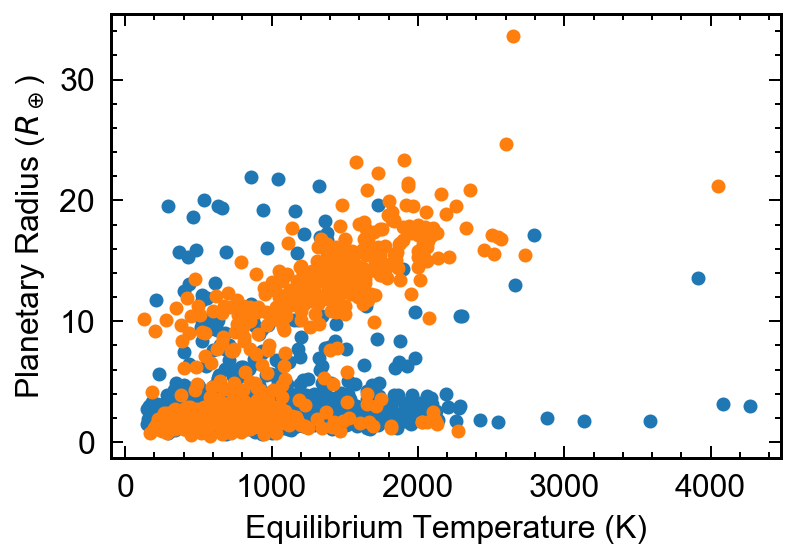

In [12]:
plt.close()
plt.scatter(T_eq, sullivan['Rp'])
plt.scatter(nexsci['Teq'], nexsci['Rp'])
plt.ylabel('Planetary Radius ($R_\oplus$)')
plt.xlabel('Equilibrium Temperature (K)')
plt.show()

### 2. I can't see all the dots in that mess! 
Let's shrink them down and make them partly transparent.

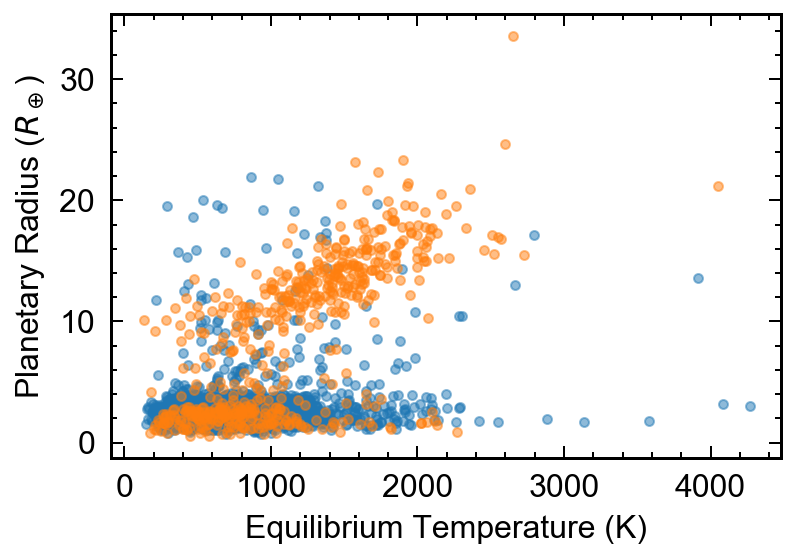

In [13]:
plt.close()
plt.scatter(T_eq, sullivan['Rp'], alpha=0.5, s=20, rasterized=True)
plt.scatter(nexsci['Teq'], nexsci['Rp'], alpha=0.5, s=20, rasterized=True)
plt.ylabel('Planetary Radius ($R_\oplus$)')
plt.xlabel('Equilibrium Temperature (K)')
plt.show()

### 3. There's a lot of empty plot space and which points are which?
The edges are technically not transparent and so there's that weird darker bit around the circles let's get rid of that too.

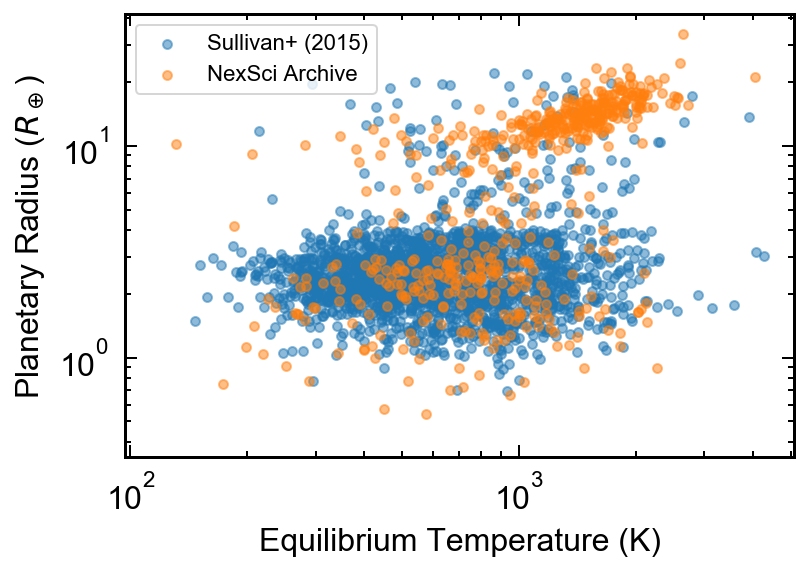

In [14]:
plt.close()
plt.scatter(T_eq, sullivan['Rp'], alpha=0.5, s=20, 
            rasterized=True, label='Sullivan+ (2015)')
plt.scatter(nexsci['Teq'], nexsci['Rp'], alpha=0.5, s=20, 
            rasterized=True, label='NexSci Archive')
plt.ylabel('Planetary Radius ($R_\oplus$)')
plt.xlabel('Equilibrium Temperature (K)')
plt.yscale('log')  # NOTE: Log axes!
plt.xscale('log')
plt.legend(loc=2)
plt.show()

### 4. Not everyone thinks in earth Radii so let's add a second axis with Jupiter radii and change the colors
To add a second axis you need to get a hold of the axes objects. There are several ways of doing this:

1. `ax = plt.gca()`, where you grab them after creating your figure
2. `fig, ax = plt.subplots()`, creating them with your figure

We are going to go with option 2 because this also gives us the reference to the figure, `fig`, and gives us more control over the final figure for when we try to save it.

Note: If you're doing multiple subplots (we are only doing 1 here) there are other ways that give you more control over where how your subplots look. Instead of `plt.subplots` there are `plt.subplot2grid` and `matplotlib.gridspec`. A good explanation of the differences can be found in the `gridspec` documentation https://matplotlib.org/users/gridspec.html

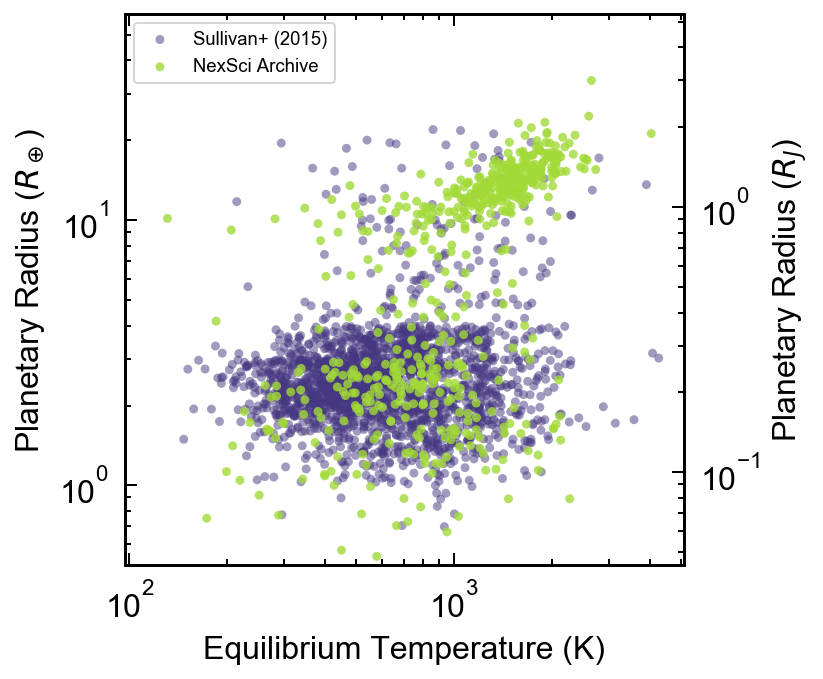

In [15]:
plt.close()
fig, ax = plt.subplots(figsize=(6,5))
# Since we have the axes now we don't plt.scatter we ax.scatter
ax.scatter(T_eq, sullivan['Rp'], s=20,
                alpha=0.5, label='Sullivan+ (2015)', facecolor=plt.cm.viridis(40), 
                rasterized=True, edgecolor='none')
ax.scatter(nexsci['Teq'], nexsci['Rp'], label='NexSci Archive',
                  alpha=.8, s=20, facecolor=plt.cm.viridis(220), 
                  rasterized=True, edgecolor='none')

ax2 = ax.twinx() # twinx to get a second y-axis. twiny to get a second x-axis

# Since we are using the ax object we now usually use ax.set_...
ax.set_yscale('log')
ax.set_xscale('log')
ax2.set_yscale('log')

ax.set_ylim([5e-1, 6e1])

# Since ax2 is based of ax we need to scale them to each other
ax2.set_ylim(ax.get_ylim()*R_earth/R_jup)
ax2.set_ylabel('Planetary Radius ($R_J$)')

ax.set_ylabel('Planetary Radius ($R_\oplus$)')
ax.set_xlabel('Equilibrium Temperature (K)')
ax.legend(fontsize='xx-small', loc=2)

plt.tight_layout() # This is important for making sure your figure 
                   # is actually all going to fit within your figure size
plt.show()

Aside: Who is viridis and why did we `plt` his `cm`?

Matplotlib has colormaps you can load in and whose values you can access by indexing the colors:

`plt.cm.viridis([0:255])`

Some plotting functions will also allow you to define the colormap you want to use with the `cmap` arg.

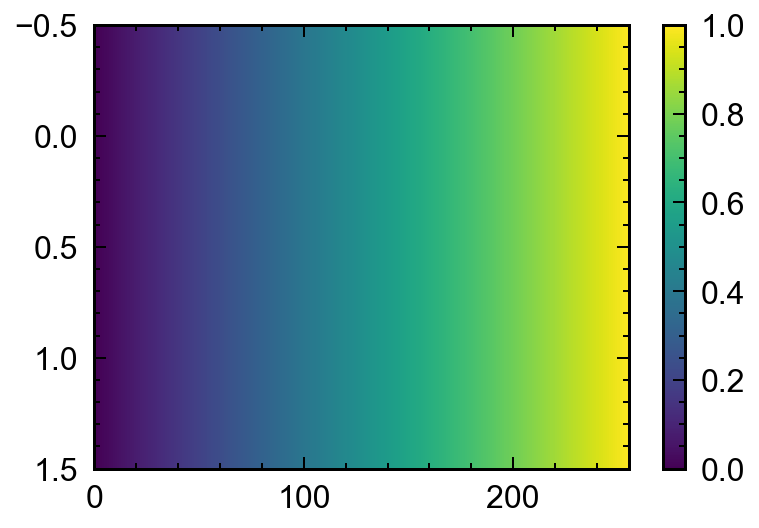

In [16]:
plt.close()
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.close()
plt.imshow(gradient, aspect='auto', cmap=plt.get_cmap("viridis"))
plt.colorbar()
plt.show()

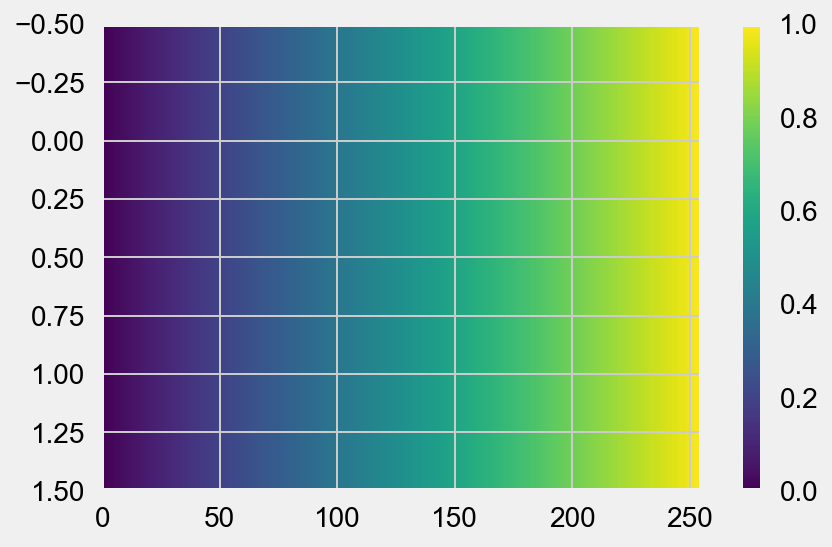

In [17]:
# You can also get fancy with style sheets...
# https://matplotlib.org/2.1.1/gallery/style_sheets/style_sheets_reference.html
with plt.style.context('fivethirtyeight'):
    plt.close()
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    plt.close()
    plt.imshow(gradient, aspect='auto', cmap=plt.get_cmap("viridis"))
    plt.colorbar()
    plt.show()

## 4. SCIENCE!

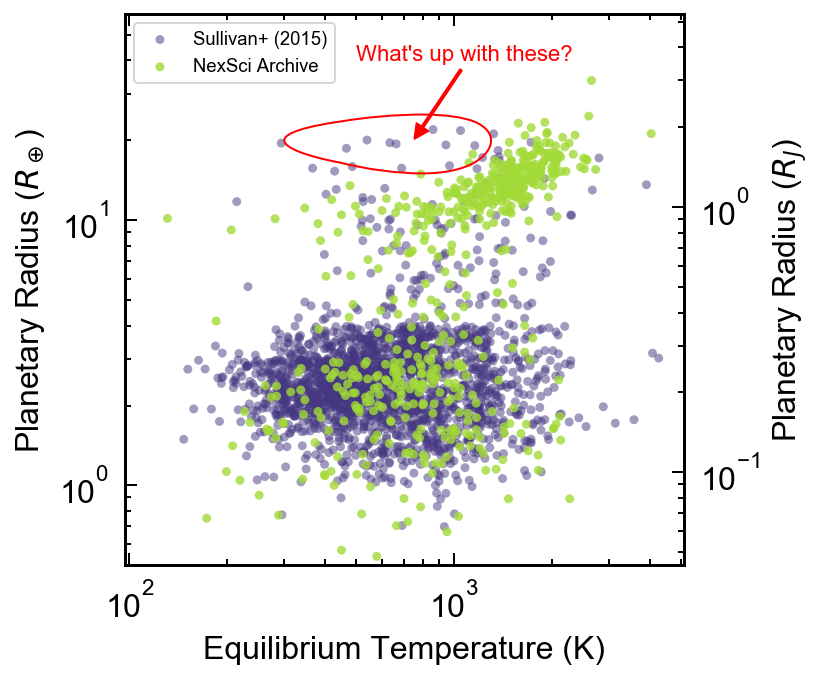

In [18]:
plt.close()
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(T_eq, sullivan['Rp'], s=20,
                alpha=0.5, label='Sullivan+ (2015)', facecolor=plt.cm.viridis(40), 
                rasterized=True, edgecolor='none')
ax.scatter(nexsci['Teq'], nexsci['Rp'], label='NexSci Archive',
                  alpha=.8, s=20, facecolor=plt.cm.viridis(220), 
                  rasterized=True, edgecolor='none')
ell = patches.Ellipse([800, 20], 1000, 10, fc='none', ec='r')
plt.annotate("What's up with these?", [750,20], [500,40], fontsize='x-small',
             arrowprops=dict(facecolor='black', shrink=0.02, ec='r', fc='r',
                             width=1, headwidth=7, headlength=7), color='r')

ax.add_artist(ell)

ax2 = ax.twinx()

ax.set_yscale('log')
ax.set_xscale('log')
ax2.set_yscale('log')

ax.set_ylim([5e-1, 6e1])
ax2.set_ylim(ax.get_ylim()*R_earth/R_jup)

ax2.set_ylabel('Planetary Radius ($R_J$)')

ax.set_ylabel('Planetary Radius ($R_\oplus$)')
ax.set_xlabel('Equilibrium Temperature (K)')
ax.legend(fontsize='xx-small', loc=2)

plt.tight_layout()
plt.show()

Daniel Thorngren and I put our heads together and figured out that based on his models for inflation of Jupiter's these planets are well beyond the limit of inflation assuming zero albedo and planet-wide heat redistribution.

Let's load up the result limit line.

In [19]:
inflation = ascii.read('inflation.csv', names=['T', 'eng', 'R'])

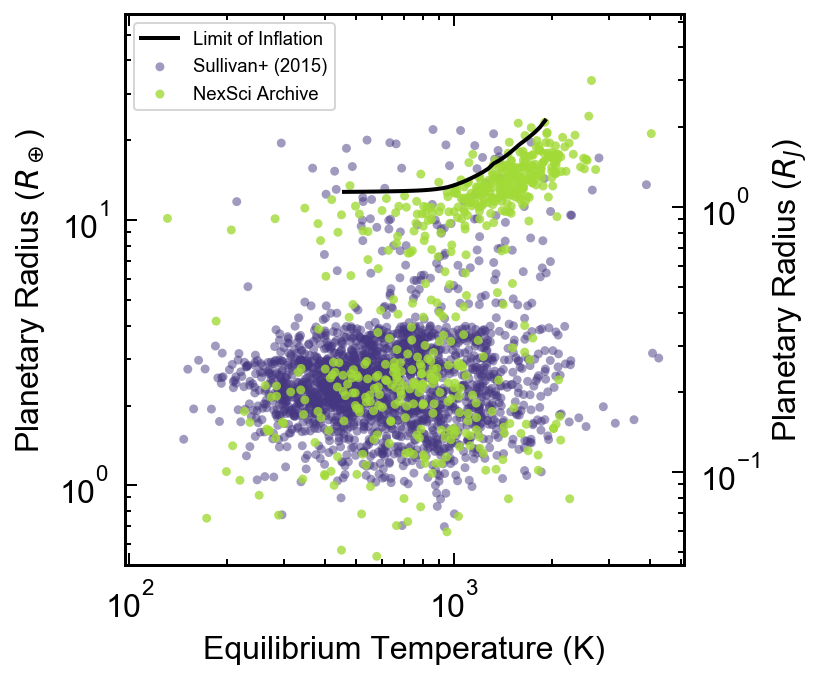

In [20]:
plt.close()
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(T_eq, sullivan['Rp'], s=20,
                alpha=0.5, label='Sullivan+ (2015)', facecolor=plt.cm.viridis(40), 
                rasterized=True, edgecolor='none')
ax.scatter(nexsci['Teq'], nexsci['Rp'], label='NexSci Archive',
                  alpha=.8, s=20, facecolor=plt.cm.viridis(220), rasterized=True, edgecolor='none')
ax.plot(inflation['T'], (inflation['R'])*R_jup/R_earth, 
               color='black', label='Limit of Inflation')
ax.set_ylabel('Planetary Radius ($R_\oplus$)')


ax2 = ax.twinx()

ax.set_yscale('log')
ax.set_xscale('log')
ax2.set_yscale('log')

ax.set_ylim([5e-1, 6e1])
ax2.set_ylim(ax.get_ylim()*R_earth/R_jup)

ax2.set_ylabel('Planetary Radius ($R_J$)')
ax.set_ylabel('Planetary Radius ($R_\oplus$)')
ax.set_xlabel('Equilibrium Temperature (K)')

ax.legend(fontsize='xx-small', loc=2)

ax.set_rasterized(True)

plt.tight_layout()
# Now save
plt.savefig('pip.pdf', format='pdf')
plt.show()

# 5. Write out our results
Let's print out a table of the planets that are above the line!

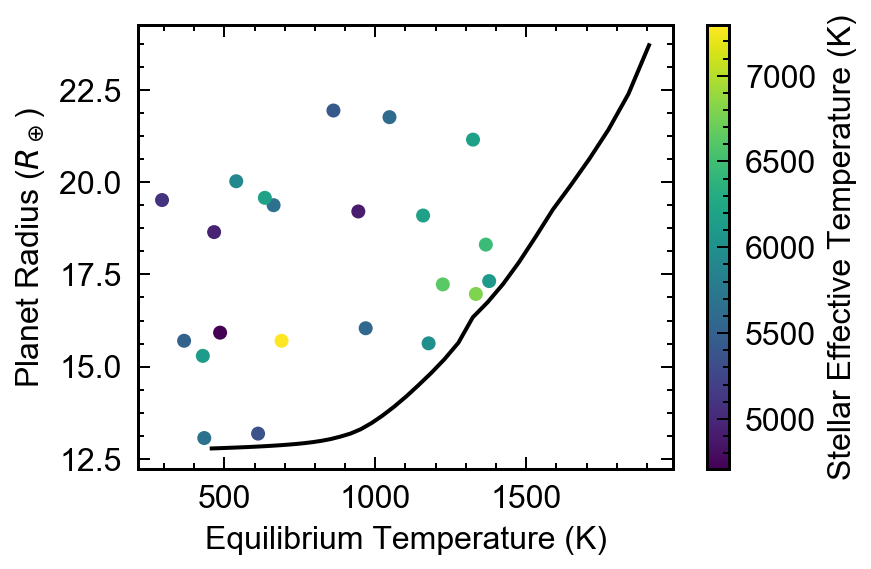

In [21]:
# Interpolate the corresponding point on the line
inflated = []
planets = np.nonzero(sullivan['Rp'] > 10*u.R_earth)[0]
for planet in planets:
    prad = np.interp(T_eq[planet].value, inflation['T'], (inflation['R'])*R_jup/R_earth)
    if sullivan['Rp'][planet] > prad*u.R_earth:
        # this planet is inflated
        inflated.append(planet)
# inflated is now a list of indices for the inflated planets

plt.close()
plt.scatter(T_eq[inflated], sullivan['Rp'][inflated], c=sullivan['Teff'][inflated], label='Inflated Planets')
# Small aside here: There are multiple ways to define point colors
# color, facecolor, edgecolor, and c; you don't need all of them!
# if you set an edgecolor you should set facecolor instead of color to be clean
# if you want different colors for each point
# like from some array the same length as x and y you can use the
# keyword 'c' instead of 'color'
# both facecolor and edgecolor will take arrays too
# see our help(plt.scatter) above!
plt.plot(inflation['T'], inflation['R']*R_jup/R_earth, color='k', label='Inflation Limit')

plt.colorbar(label='Stellar Effective Temperature (K)')

plt.ylabel('Planet Radius ($R_\oplus$)')
plt.xlabel('Equilibrium Temperature (K)')

plt.show()

ascii.write([T_eq[inflated], sullivan['Rp'][inflated]], 
            format='aastex', names=['eq. T', '$R_p$'], 
            output='inflatedplanet.txt', formats={'eq. T':'%.i', '$R_p$':'%.3f'}, 
            overwrite=True, col_align='RR', \
            latexdict={'caption':'Inflated plaents in the Sullivan et al. (2015) sample.'})